In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from langdetect import detect
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
titles = pd.read_table('data/title.basics.tsv', usecols=['tconst', 'primaryTitle'])
ratings = pd.read_table('data/title.ratings.tsv')

In [3]:
# Let's convert films ids into strings
titles['id'] = titles.tconst.apply(lambda s: int(s[2:]))
ratings['id'] = ratings.tconst.apply(lambda s: int(s[2:]))
print(titles[titles['id'].duplicated()].shape) # Checking that there are no duplicates
print(ratings[ratings['id'].duplicated()].shape) # Checking that there are no duplicates

(0, 3)
(0, 4)


In [4]:
titles.set_index('id', inplace=True)
ratings.set_index('id', inplace=True)

In [5]:
titles.drop(['tconst'], axis=1, inplace=True)
ratings.drop(['tconst'], axis=1, inplace=True)

In [28]:
from time import time

rated_films_ids = set(ratings[ratings.numVotes > 5000].index.values)
# rated_titles = titles[titles.index.isin(rated_films_ids)]
rated_titles = titles[titles.index.isin(rated_films_ids)].copy()


i = 0
def detect_title_lang(title):
    global i
    i += 1
    if i % 100 == 0: print('Iterations done: {}/{}'.format(i, rated_titles.shape[0]))
    try:
        return detect(title)
    except KeyboardInterrupt:
        raise
    except:
        return 'unknown'


start = time()
rated_titles['lang'] = rated_titles.primaryTitle.apply(detect_title_lang)
print('Took {:.1f} seconds'.format(time() - start))

Iterations done: 100/13290
Iterations done: 200/13290
Iterations done: 300/13290
Iterations done: 400/13290
Iterations done: 500/13290
Iterations done: 600/13290
Iterations done: 700/13290
Iterations done: 800/13290
Iterations done: 900/13290
Iterations done: 1000/13290
Iterations done: 1100/13290
Iterations done: 1200/13290
Iterations done: 1300/13290
Iterations done: 1400/13290
Iterations done: 1500/13290
Iterations done: 1600/13290
Iterations done: 1700/13290
Iterations done: 1800/13290
Iterations done: 1900/13290
Iterations done: 2000/13290
Iterations done: 2100/13290
Iterations done: 2200/13290
Iterations done: 2300/13290
Iterations done: 2400/13290
Iterations done: 2500/13290
Iterations done: 2600/13290
Iterations done: 2700/13290
Iterations done: 2800/13290
Iterations done: 2900/13290
Iterations done: 3000/13290
Iterations done: 3100/13290
Iterations done: 3200/13290
Iterations done: 3300/13290
Iterations done: 3400/13290
Iterations done: 3500/13290
Iterations done: 3600/13290
I

In [45]:
en_titles = rated_titles[rated_titles.lang == 'en'].primaryTitle.values

In [96]:
import nltk
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
stemmer = LancasterStemmer()
en_stopwords = stopwords.words('english')
en_stopwords = [t for w in en_stopwords for t in nltk.word_tokenize(w)]
en_stopwords = [stemmer.stem(w) for w in en_stopwords]
en_stopwords = set(en_stopwords)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/universome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/universome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
tokens = [[stemmer.stem(t) for t in nltk.word_tokenize(s)] for s in en_titles]
tokens = [[t for t in s if not t in en_stopwords] for s in tokens]

In [118]:
data = pd.DataFrame({'inputs': tokens, 'targets': en_titles})

In [119]:
# Dropping examples without tokens
data['num_tokens'] = data.inputs.apply(lambda x: len(x))
data = data[data.num_tokens != 0]

In [151]:
tokenize_sentence = lambda s: ' '.join(nltk.word_tokenize(s))

inputs = [' '.join(s) for s in data.inputs.values.tolist()]
targets = [tokenize_sentence(s) for s in data.targets.values.tolist()]
targets = [s.lower() for s in targets]
pairs = [(inputs[i], targets[i]) for i in range(len(inputs))]

# Training the model

In [138]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2 # Count SOS and EOS
        
        self.add_word('UNKNOWN') # Adding unknown token

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [153]:
source_lang = Lang('source')
target_lang = Lang('target')

for s in inputs: source_lang.add_sentence(s)
for s in targets: target_lang.add_sentence(s)

In [290]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


MAX_LENGTH = 20
SOS_token = 0
EOS_token = 1
use_cuda = torch.cuda.is_available()


class Encoder(nn.Module):
    def __init__(self, hidden_size, input_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights

    def init_hidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

In [329]:
def word_to_index(lang, word, unknown_noise_prob=0.1):
    if word in lang.word2index and random.random() > unknown_noise_prob:
        return lang.word2index[word]
    else:
        return lang.word2index['UNKNOWN']

    
def sentence_to_index(lang, sentence):
    return [word_to_index(lang, word) for word in sentence.split(' ')]


def sentence_to_var(lang, sentence):
    indexes = sentence_to_index(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    
    return result.cuda() if use_cuda else result


def pair_to_var(pair):
    input_variable = sentence_to_var(source_lang, pair[0])
    target_variable = sentence_to_var(target_lang, pair[1])
    
    return (input_variable, target_variable)

In [292]:
import random
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()

    optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden
    use_teacher_forcing = random.random() < teacher_forcing_ratio

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input


            loss += criterion(decoder_output, target_variable[di])
            
            if ni == EOS_token:
                break

    loss.backward()
    optimizer.step()

    return loss.data[0] / target_length

In [339]:
from tqdm import tqdm_notebook as tqdm

learning_rate = 1e-3
hidden_size = 64
encoder = Encoder(hidden_size, source_lang.n_words)
decoder = Decoder(hidden_size, target_lang.n_words)

optimizer = torch.optim.Adam([
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
], lr=learning_rate)

criterion = nn.NLLLoss()

losses = []

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    loss = 0
    
    for pair in pairs[:10]:
        input_var, target_var = pair_to_var(pair)
        loss += train(input_var, target_var, encoder, decoder, optimizer, criterion)
    
    losses.append(loss)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

RuntimeError: inconsistent tensor sizes at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/TH/generic/THTensorMath.c:2864

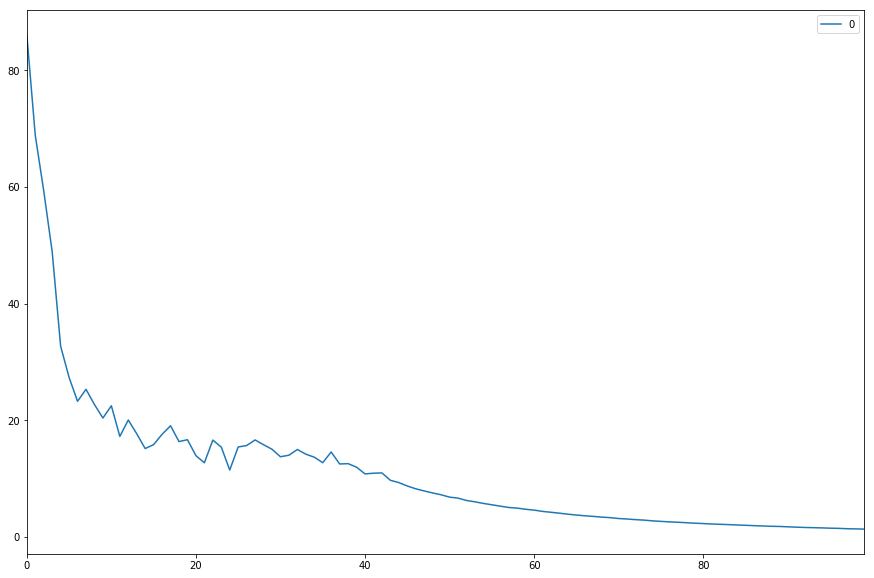

In [317]:
pd.DataFrame(losses).plot(figsize=(15,10))

In [330]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = sentence_to_var(source_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.init_hidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(target_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [331]:
evaluate(encoder, decoder, 'chair human')

(['the', 'birth', 'of', 'a', 'nation', '<EOS>'], 
 
 Columns 0 to 9 
  0.0011  0.4218  0.5528  0.0100  0.0013  0.0005  0.0046  0.0007  0.0008  0.0008
  0.0001  0.9975  0.0016  0.0002  0.0001  0.0000  0.0002  0.0000  0.0000  0.0000
  0.0008  0.8385  0.0893  0.0476  0.0102  0.0024  0.0031  0.0009  0.0004  0.0010
  0.0004  0.4694  0.5158  0.0095  0.0009  0.0002  0.0009  0.0002  0.0002  0.0005
  0.0003  0.9933  0.0051  0.0002  0.0001  0.0001  0.0003  0.0000  0.0000  0.0001
  0.0015  0.2381  0.7200  0.0212  0.0020  0.0005  0.0038  0.0007  0.0013  0.0013
 
 Columns 10 to 19 
  0.0003  0.0003  0.0007  0.0005  0.0004  0.0003  0.0008  0.0006  0.0014  0.0004
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0003  0.0005  0.0009  0.0005  0.0003  0.0002  0.0010  0.0006  0.0013  0.0003
  0.0002  0.0002  0.0004  0.0002  0.0001  0.0001  0.0003  0.0002  0.0003  0.0001
  0.0000  0.0000  0.0001  0.0000  0.0000  0.0000  0.0001  0.0000  0.0001  0.0000
  0.0011  0.0008  0

In [321]:
evaluate(encoder, decoder, pairs[0][0])

(['the', 'arrival', 'of', 'a', 'train', '<EOS>'], 
 
 Columns 0 to 9 
  0.0017  0.7110  0.2586  0.0094  0.0014  0.0004  0.0044  0.0006  0.0009  0.0014
  0.0003  0.9920  0.0034  0.0012  0.0004  0.0002  0.0004  0.0001  0.0001  0.0002
  0.0045  0.3358  0.4417  0.0775  0.0547  0.0054  0.0275  0.0043  0.0039  0.0045
  0.0007  0.4017  0.5775  0.0126  0.0013  0.0003  0.0010  0.0004  0.0003  0.0011
  0.0002  0.9940  0.0047  0.0003  0.0001  0.0000  0.0001  0.0000  0.0000  0.0001
  0.0005  0.9853  0.0087  0.0024  0.0002  0.0001  0.0010  0.0001  0.0001  0.0002
 
 Columns 10 to 19 
  0.0003  0.0005  0.0010  0.0015  0.0010  0.0003  0.0008  0.0011  0.0029  0.0005
  0.0001  0.0001  0.0002  0.0002  0.0001  0.0001  0.0001  0.0002  0.0004  0.0001
  0.0028  0.0047  0.0054  0.0026  0.0071  0.0023  0.0078  0.0021  0.0041  0.0013
  0.0003  0.0002  0.0004  0.0002  0.0003  0.0002  0.0004  0.0003  0.0007  0.0002
  0.0000  0.0000  0.0001  0.0000  0.0000  0.0000  0.0000  0.0001  0.0001  0.0000
  0.0001  0.0001  